In [1]:
import numpy as np
import matplotlib.pyplot as plt

ME = 3.0404327497692654e-06 #earth mass
ObliqE = np.radians(23.439291111111)  #earth obliquity
G = 0.01720209895**2

#earth mean anomaly
earth_M = np.radians((100.46435-(-11.26064)-114.20783)) 

Phot_G = 0.15

#all angle inputs converted to radians

J0 = 2451545.0000000000

#observations
JD1 = 2452465.5000000000000000
RA1 = np.radians(93.9350137072466680)
Dec1 = np.radians(38.1582374014492629)
mag1 = 12.026

JD2 = 2452470.5000000000000000
RA2 = np.radians(95.6958342344323825)
Dec2 = np.radians(38.0852446940591847)
mag2 = 12.043

JD3 = 2452480.5000000000000000
RA3 = np.radians(99.0739551229480071)
Dec3 = np.radians(37.9339616031920031)
mag3 = 12.063

JD4 = 2452468.5000000000000000
RA4 = np.radians(94.9970501725531307)
Dec4 = np.radians(38.1147826741125755)
mag4 = 12.037

JD5 = 2452474.5000000000000000
RA5 = np.radians(97.0706479192634788)
Dec5 = np.radians(38.0251849185151869)
mag5 = 12.053

Tau1 = JD3-JD2
Tau2 = JD3-JD1
Tau3 = JD2-JD1

a1 = Tau1/Tau2
a3 = Tau3/Tau2

print('sector ratios')
print('b1:', a1)
print('b3:', a3)

JD = np.array([JD1,JD2,JD3])
RA = np.array([RA1,RA2,RA3])
Dec = np.array([Dec1,Dec2,Dec3])
mag = np.array([mag1,mag2,mag3])

sector ratios
b1: 0.6666666666666666
b3: 0.3333333333333333


In [2]:
################## Q1 #########################

def PosVel(m1,m2,a,e,E):
    
    '''
    Takes in orbital elements and returns x,y, and z positions and 
    velocities
    
        Parameters:
            m1 (float): mass of first body (solar masses)
            m2 (float): mass of second body (solar masses)
            a (float): semi-major axis (au)
            e (float): eccentricity (unitless)
            E (float): true anomaly (radians)
        
        Returns
            r (array): position vector (au)
            v (array): velocity vector (au/day)
    '''
    
    mu = G*(m1+m2)
    n = (mu/a**3)**0.5
    
    x = a*(np.cos(E)-e)
    y = a*((1-e**2)**0.5)*np.sin(E)
    z = 0
    
    r = x,y,z
    
    xdot = -a*n*np.sin(E)/(1-e*np.cos(E))
    ydot = a*((1-e**2)**0.5)*n*np.cos(E)/(1-e*np.cos(E))
    zdot = 0
    
    v = x,y,z
    return(r,v)

def RotMat(r, v, w, i, Omega):
    '''
    Takes in position and velocity vectors, rotates them through
    angles w, i,and Omega, and returns rotated positions and velocity 
    vectors.
    
        Parameters:
            r (array) = position vector (x, y, z) (AU)
            v (array) = velocity vector (xdot, ydot, zdot) (AU/day)
            w (float) = argument of periapsis (radians)
            i (float) = inclination (radians)
            Omega (float) = longitude of the ascending node (radians)
    
        Returns:
            r (array) = rotated position vector (AU)
            v (array) = rotated velocity vector (AU/day)
    
    '''
    i = -i
    w = -w
    Omega = -Omega

    #rotate around z by omega, then x by i, then z by Omega
    mat_z = np.array([[np.cos(w), np.sin(w), 0],
                      [-np.sin(w), np.cos(w), 0],
                      [0, 0, 1]])
    
    mat_x = np.array([[1, 0, 0],
                  [0, np.cos(i), np.sin(i)],
                  [0, -np.sin(i), np.cos(i)]])
    
    mat_z2 = np.array([[np.cos(Omega), np.sin(Omega), 0],
                      [-np.sin(Omega), np.cos(Omega), 0],
                      [0, 0, 1]])
    
    r = np.dot(mat_z, r)
    v = np.dot(mat_z, v)
    
    r = np.dot(mat_x, r)
    v = np.dot(mat_x, v)
    
    r = np.dot(mat_z2, r)
    v = np.dot(mat_z2, v)


    return (r, v)

In [3]:
def KeplerE(e, M):
    '''
    Solves Keplers equation iteratively. Initial guess for E is set 
    equal to M.
    
        Parameters:
            e (float) = eccentricity (unitless)
            M (float) = mean anomaly (radians)
    
        Returns:
            E (float) = Eccentric anomaly (radians)
    '''
    E = M
    it = 0
    tol = 1e-12
    maxit = 100
    
    while it < maxit:
        
        initial = E - e*np.sin(E) - M
        derivative = 1 - e*np.cos(E)
        delta = -initial/derivative
        
        E += delta
        it += 1
        
        if abs(delta) < tol:
            break  
        if it == maxit:
            print('no convergence')
            
    return(E)

In [4]:
def Cartographic(m1, m2, a, e, i, Omega, w, E):
    '''
    Takes in masses and orbital elements of a body and returns
    cartographic position and velocity vectors
    
        Parameters: 
            m1 (float) = mass of first body (solar masses )
            m2 (float) = mass of second body (solar masses)
            a (float) = semi-major axis (AU)
            e (float) = eccentricity 
            i (float) = inclination (radians)
            Omega (float) = longitude of the ascending node (radians)
            w (float) = argument of periapsis (radians)
            E (float) = eccentric anomaly (radians)
    
        Returns:
            r_helioeclip (array) = position vector in the heliocentric 
            ecliptic frame (AU)
    
            v_helioeclip (array) = velocity vector in the heliocentric 
            ecliptic frame (AU/day)
    
    '''
    
    r,v = PosVel(m1, m2, a, e, E)
    
    r_helioeclip, v_helioeclip = RotMat(r, v, w, i, Omega)
    
    return(r_helioeclip, v_helioeclip)

In [5]:
def JD_to_HelioEclip(JD,m1,m2, a=1.00000011, e=0.01671022, 
                     i=np.radians(0.00005), Omega=np.radians(-11.26064),
                     w=np.radians(102.94719+11.26064), 
                     M=np.radians(100.46435-(102.94719+11.26064)+11.26064),
                     J0=2451545.0):
    """
    Takes in JD, masses, and orbital elements and returns position and 
    veclocity vectors in the heliocentric ecliptic frame, default 
    values for earth
    
        Parameters:
            JD (float) = Julian date (unitless)
            m1 (float) = mass of first body (solar masses )
            m2 (float) = mass of second body (solar masses)
            a (float) = semi-major axis (AU)
            e (float) = eccentricity 
            i (float) = inclination (radians)
            Omega (float) = longitude of the ascending node (radians)
            w (float) = argument of periapsis (radians)
            M (float) = mean anomaly (radians)
            J0 (float) = reference epocch Julian Date
    
        Returns:
            r (array) = heliocentric position vector (AU)
            v (array) = heliocentic velocity vector (AU/day)
    
    """
    mu = 0.01720209895**2*(m1+m2)

    n = np.sqrt(mu/a**3)
    
    M = (M + n * (JD - J0))%( 2*np.pi )
    
    E = KeplerE(e, M)

    r, v = Cartographic(m1, m2, a, e, i, Omega, w, E)
    
    return r, v

In [6]:
def RaDec(RA,dec):
    '''
    Takes in Right Ascension and Declination and returns 
    x, y, and z positions
    
        Parameters:
            RA (float) = Right Ascension (radians)
            dec (float) = declination (radians)
        
        Returns:
            x (float): x position (au)
            y (float): y position (au)
            z (float): z position (au)
        
    '''
    
    x = np.cos(RA)*np.cos(dec)
    y = np.sin(RA)*np.cos(dec)
    z = np.sin(dec)
    
    return(x,y,z)

def ObliqRot(obliq,r):
    
    '''
    Takes in obliquity angle and position vector, rotates
    vector around the x axis by that angle, and returns rotated vector
    
        Parameters:
            Obliq (float): Obliquity angle (radians)
            r (array): Position vector (au)
        
        Returns:
            r (array): rotated position vector (au)
    '''

    mat = np.array(([1,0,0],
              [0,np.cos(obliq),np.sin(obliq)],
              [0,-np.sin(obliq),np.cos(obliq)]))
    
    r = np.dot(mat,r)
    
    return(r)

In [7]:
def f_g_func(sigma,t,t0):
    
    '''
    Takes in sigma, t, and t0, and returns f and g functions needed for 
    velocity calculations
        
        Parameters:
            sigma (float): sigma constant 
            t (float): final time of obsvertation (JD)
            t0 (float): inital time of observation (JD)
        
        returns:
            f(float): constant
            g(float): constant
    '''
    
    f = 1 - (0.5*sigma*(t-t0)**2)
    g = (t-t0) - ((1/6)*sigma*(t-t0)**3)
    
    return(f,g)

def vel(r,r0,t,t0,rho):
    
    '''
    Takes in inital and final heliocentric position vectors, and returns 
    velocity caluclations
    
        Parameters:
            r (array): helio centric final position vector (AU)
            r0 (array): helio centric initial positions vector (AU)
            t (float): final time of observation (JD)
            t0 (float): initial time of observation (JD)
        
        Returns:
            v0 (array): velocity vector of initial observation (AU/day)
        
    '''
    
    sigma = G/(np.linalg.norm(rho)**3)
    f,g = f_g_func(sigma,t,t0)
    
    v0 = (r - f*r0)/g
    return(v0)

In [8]:
def OrbEl_from_PosVel(m1,m2,x,y,z,vx,vy,vz):
    '''
    Takes in 2 masses, position vector, and velocity vector
    returns standard orbital elements
    
        Parameters:
            m1 (float): Mass of first body (solar masses)
            m2 (float): Mass of second body (solar masses)
            x (float): x coordinate of position vector (au)
            y (float): y coordinate of position vector (au)
            z (float): z coordinate of position vector (au)
            vx (float): x coordinate of velocity vector (au/day)
            vy (float): y coordinate velocity vector (au/day)
            vz (float): z coordinate of velocity vector (au/day)
        Returns:
            a (float): Semi-Major Axis (au)
            e (float): Eccentricity (unitless)
            i (float): inclination angle (radians)
            w (float): Argument of Perihelion (radians)
            Omega (float): Longitude of the Ascending Node (radians)
            f (float): True Anomaly (radians )
    '''
    
    mu = G*(m1+m2)
    
    r = np.array([x,y,z])
    v = np.array([vx,vy,vz])
    h = np.cross(r,v)
    
    hx, hy, hz = h[0], h[1], h[2]
    
    rmag = np.linalg.norm(r)
    vmag = np.linalg.norm(v)
    hmag = np.linalg.norm(h)
    
    
    
    a = 1/((2/rmag) - (vmag**2/mu)) 
    e = np.sqrt((1-(hmag**2/(mu*a))))      
    i = np.arctan2(np.sqrt(hx**2+hy**2),hz) 
    
    if e>=0 and i>=0: #check if i or e are precisely zero
    
        sinOm = hx/np.sqrt(hx**2+hy**2)
        cosOm = -hy/np.sqrt(hx**2+hy**2)
    
        Omega = np.arctan2(sinOm,cosOm)
    
        cosf = (hmag**2/((mu*rmag)) - 1)
        sinf = ((np.dot(r,v))*hmag/(mu*rmag))
    
        f = np.arctan2(sinf,cosf)
    
        sinOmf = (z*hmag/np.sqrt(hx**2+hy**2))
        cosOmf = (x*np.cos(Omega) + y*np.sin(Omega))
    
        w = np.arctan2(sinOmf,cosOmf) - f
    
        #Make sure omega is in the right quadrant
        if w<0:
            w = w+2*np.pi
        else:
            w = w
            
    if e==0:
        #This prints a warning but still completes calculations
        print('Warning: eccentricity is zero')
    if i==0:
        print('Warning: Inclination angle is zero')
    elif e<0:
        print('Negative eccentricity, cannot complete calculations')
    elif i<0:
        print('Negative inclination angle, cannot complete calculations')
    
    return(a, e, i, w, Omega, f)

In [9]:
def RaDec_Cunningham (JD,a,d):
    
    '''
    Takes in 3 observations of julian dates, right ascension, 
    and declination, and returns heliocentric and geocentric vectors.
    
        Parameters:
            JD (array): array of 3 Julian Dates (unitless)
            a (array): array of 3 right ascensions (radians)
            d (array): array of 3 declinations (radians)
            
        Returns:
            r1_helio,r2_helio,r3_helio (array): Heliocentric position
                                                    vectors (au)
            r1_geo,r2_geo,r3_geo (array): Geocentric positions vecotrs (au)
            
            rho1,rho2,rho3 (float): geocentric distances (au)
    '''
    
    r1 = JD_to_HelioEclip(JD[0], 1, ME, J0 = 2451545.0)[0]
    r2 = JD_to_HelioEclip(JD[1], 1, ME, J0 = 2451545.0)[0]
    r3 = JD_to_HelioEclip(JD[2], 1, ME, J0 = 2451545.0)[0]
    
    rho1_hat = RaDec(RA[0],Dec[0])
    rho2_hat = RaDec(RA[1],Dec[1])
    rho3_hat = RaDec(RA[2],Dec[2])
    
    xi = rho1_hat
    
    eta = (np.cross(rho1_hat,np.cross(rho3_hat,rho1_hat))/
    np.linalg.norm(np.cross(rho1_hat,np.cross(rho3_hat,rho1_hat))))
    
    zeta = np.cross(xi,eta)
    
    cunningham_mat = np.array([xi,eta,zeta])
    
    rho1_hat_c = np.dot(cunningham_mat,rho1_hat)
    rho2_hat_c = np.dot(cunningham_mat,rho2_hat)
    rho3_hat_c = np.dot(cunningham_mat,rho3_hat)
    
    lambda1,mu1,nu1 = rho1_hat_c
    lambda2,mu2,nu2 = rho2_hat_c
    lambda3,mu3,nu3 = rho3_hat_c
    
    R1 = np.dot(cunningham_mat,ObliqRot(-ObliqE,-1*r1))
    R2 = np.dot(cunningham_mat,ObliqRot(-ObliqE,-1*r2))
    R3 = np.dot(cunningham_mat,ObliqRot(-ObliqE,-1*r3))
    
    X1,Y1,Z1 = R1
    X2,Y2,Z2 = R2
    X3,Y3,Z3 = R3

    rho2 = ((-a1*Z1)+(Z2)-(a3*Z3))/nu2
    rho3 = ((rho2*mu2)+(a1*Y1)-Y2+(a3*Y3))/(a3*mu3)
    rho1 = ((rho2*lambda2)-(a3*rho3*lambda3)+(a1*X1)-X2+(a3*X3))/a1

    r1_c = rho1*rho1_hat_c - R1
    r2_c = rho2*rho2_hat_c - R2
    r3_c = rho3*rho3_hat_c - R3
    
    r1_geo_c = rho1*rho1_hat_c
    r2_geo_c = rho2*rho2_hat_c
    r3_geo_c = rho3*rho3_hat_c

    r1_helio = np.dot(cunningham_mat.T,r1_c)
    r1_helio = ObliqRot(ObliqE,r1_helio)
    
    r2_helio = np.dot(cunningham_mat.T,r2_c)
    r2_helio = ObliqRot(ObliqE,r2_helio)
    
    r3_helio = np.dot(cunningham_mat.T,r3_c)
    r3_helio = ObliqRot(ObliqE,r3_helio)
    
    r1_geo = np.dot(cunningham_mat.T,r1_geo_c)
    r1_geo = ObliqRot(ObliqE,r1_geo)
    
    r2_geo = np.dot(cunningham_mat.T,r2_geo_c)
    r2_geo = ObliqRot(ObliqE,r2_geo)
    
    r3_geo = np.dot(cunningham_mat.T,r3_geo_c)
    r3_geo = ObliqRot(ObliqE,r3_geo)
    
    
    print('nu2:',nu2)
    
    print('Heliocentric distances:')
    print('r1:',np.linalg.norm(r1_helio))
    print('r2:',np.linalg.norm(r2_helio))
    print('r3:',np.linalg.norm(r3_helio))
    print()
    print('Geocentric distances')
    print('r1:',np.linalg.norm(r1_geo))
    print('r2:',np.linalg.norm(r2_geo))
    print('r3:',np.linalg.norm(r3_geo))
    
    
    return(r1_helio,r2_helio,r3_helio,r1_geo,r2_geo,r3_geo,rho1,rho2,rho3)

In [10]:
def OrbEl(JD,RA,Dec): ####### main function for q1
    
    '''Main Orbital elements function, takes in Julian Date, 
    Right Ascension, and Declination, calls functions which calculate 
    heliocentric and geocentric position vectors, calculates 
    velcocity vectors from helio positions, and uses heliocentric 
    position and velocity to calculate orbital elements of the object. 
    Returns the mean of the orbital elements over three observations 
    except for f, for which the f from the second observation is 
    returned.
    
        Parameters:
            JD (array): array of 3 Julian Dates (unitless)
            a (array): array of 3 right ascensions (radians)
            d (array): array of 3 declinations (radians)
            
        Returns:
            a (float): Semi-Major Axis (au)
            e (float): Eccentricity (unitless)
            i (float): inclination angle (radians)
            w (float): Argument of Perihelion (radians)
            Omega (float): Longitude of the Ascending Node (radians)
            f2 (float): True Anomaly at second observation (radians)
            a_err (float): standard deviation of Semi-Major Axis (au)
            e_err (float): standard deviation Eccentricity (unitless)
            i_err (float): standard deviation inclination angle (radians)
            w_err (float): standard deviation Argument of Perihelion (radians)
            Omega_err (float): standard deviation Longitude of the Ascending 
                                                                Node (radians)
            
    '''
    
    r1_helio,r2_helio,r3_helio,r1_geo,r2_geo,r3_geo,rho1,rho2,rho3 = RaDec_Cunningham(JD,RA,Dec)
    
    x1,y1,z1 = r1_helio
    x2,y2,z2 = r2_helio
    x3,y3,z3 = r3_helio
    
    xdot1,ydot1,zdot1 = vel(r2_helio,r1_helio,JD2,JD1,rho1)
    xdot2,ydot2,zdot2 = vel(r3_helio,r1_helio,JD3,JD1,rho1)
    xdot3,ydot3,zdot3 = vel(r3_helio,r2_helio,JD3,JD2,rho3)
    
    a1,e1,i1,w1,Omega1,f1 = OrbEl_from_PosVel(1,0,x1,y1,z1,xdot1,ydot1,zdot1)
    a2,e2,i2,w2,Omega2,f2 =  OrbEl_from_PosVel(1,0,x2,y2,z2,xdot2,ydot2,zdot2)
    a3,e3,i3,w3,Omega3,f3 = OrbEl_from_PosVel(1,0,x3,y3,z3,xdot3,ydot3,zdot3)
    
    a_err = np.std([a1,a2,a3])
    e_err = np.std([e1,e2,e3])
    i_err = np.std([i1,i2,i3])
    w_err = np.std([w1,w2,w3])
    Omega_err = np.std([Omega1,Omega2,Omega3])

    a = np.mean([a1,a2,a3])
    e = np.mean([e1,e2,e3])
    i = np.mean([i1,i2,i3])
    w = np.mean([w1,w2,w3])
    Omega = np.mean([Omega1,Omega2,Omega3])
    
    return(a,e,i,w,Omega,f2,a_err,e_err,i_err,w_err,Omega_err)

a,e,i,w,Omega,f2,a_err,e_err,i_err,w_err,Omega_err = OrbEl(JD,RA,Dec)

nu2: -0.0003747102052722995
Heliocentric distances:
r1: 3.603010089422941
r2: 3.6375943150484464
r3: 3.707658728723964

Geocentric distances
r1: 4.537769590146244
r2: 4.552588569639063
r3: 4.57024707031072


In [11]:
#some print statements to make it a little easier
#to see what the orbital elements are

print("semimajor axis (a):", np.round(a,3))
print('Standard deviation:',np.round(a_err,3),'au')
print()

print('eccentricity (e):', np.round(e,3))
print('Standard deviation:',np.round(e_err,3),'au')
print()

print('inclination (i):', np.round(i,3),'radians or', 
          np.round(i*180/np.pi,3),'degrees')
print('Standard deviation:',np.round(i_err,18),'radians')
print()

print('argument of perihleion (omega):', np.round(w,3),
          'radians or',np.round(w*180/np.pi,3),'degrees')
print('Standard deviation:',np.round(w_err,4),'radians')
print()

print('Longitude of the Ascending Node (Omega):', 
          np.round(Omega,3),'radians or', np.round(Omega*180/np.pi,3),
          'degrees' )
print('Standard deviation:',np.round(Omega_err,18),'radians')
print()

print('True anomaly (f2):', np.round(f2,3),'radians or',
          np.round(f2*180/np.pi,3), 'degrees')
print()

print('perihelion',np.round(a*(1-e),3),'au')
print('aphelion',np.round(a*(1+e),3),'au')
print('period', np.round(np.sqrt(a**3),3),'years')

semimajor axis (a): 4.276
Standard deviation: 0.127 au

eccentricity (e): 0.735
Standard deviation: 0.009 au

inclination (i): 0.437 radians or 25.012 degrees
Standard deviation: 1.536e-15 radians

argument of perihleion (omega): 0.041 radians or 2.348 degrees
Standard deviation: 0.0102 radians

Longitude of the Ascending Node (Omega): -0.776 radians or -44.466 degrees
Standard deviation: 4.272e-15 radians

True anomaly (f2): 2.248 radians or 128.821 degrees

perihelion 1.131 au
aphelion 7.421 au
period 8.842 years


In [12]:
################### Q2 ##########################

In [13]:

# need a new function dependent on f
def HelioEclip_f(m1,m2,a,e,f,w,i,Omega):
    
    '''
    Takes in two masses and orbital elements, calls a function which
    generates position and velocity vectors from that, then calls
    a function which rotates those vectors into heliocentric
    eccliptic coordinates
    
        Parameters:
        m1 (float): mass of first body (solar masses)
        m2 (float): mass of second body (solar masses)
        a (float): semi-major axis (au)
        e (float): eccentricity (unitless)
        f (float): true anomaly (degrees)
        w (float): argument of perihelion (degrees)
        i (float): inclination angle (degrees)
        
        Returns:
        x (float): x position (au)
        y (float): y position (au)
        z (float): z position (au)
        xdot (float): x velocity (au/year)
        ydot (float): y velocity (au/year)
        zdot (float): z velocity (au/year)
    '''
    
    r,vel = PosVel(m1,m2,a,e,f)
    
    r,vel = RotMat(r,vel,w,i,Omega)
    
    x,y,z = r
    xdot,ydot,zdot = vel
    return(x,y,z,xdot,ydot,zdot)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


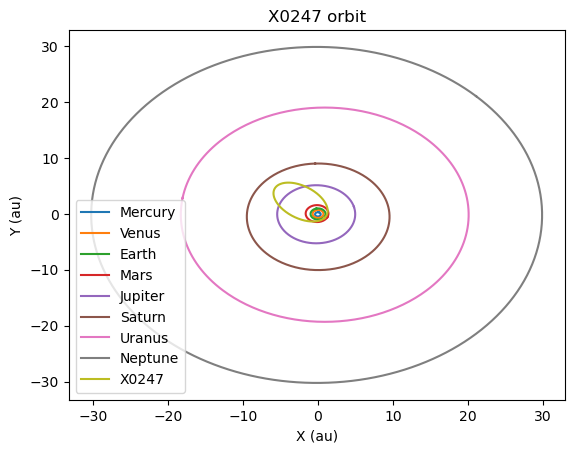

In [14]:


f = np.radians(np.arange(0,361,1))

#get little omega from ~omega and big Omega in table
w_mercury=np.radians(77.456-48.332)
w_venus=np.radians(131.533-76.601)
w_earth =np.radians(102.947-(-11.260))
w_mars = np.radians(336.041-49.579)
w_jupiter = np.radians(14.754-100.556)
w_saturn = np.radians(92.432-113.715)
w_uranus = np.radians(170.964-74.230)
w_neptune = np.radians(44.971-131.722)
w_pluto = np.radians(224.067-110.303)


#all the plots

#planet orbits
x_mercury, y_mercury,z_mercury = HelioEclip_f(1,0,0.387,0.206,f,w_mercury,np.radians(7.005),np.radians(48.332))[0:3]
x_venus, y_venus,z_venus = HelioEclip_f(1,0,0.723,0.00677,f,w_venus,np.radians(3.395),np.radians(76.681))[0:3]
x_earth, y_earth,z_earth = HelioEclip_f(1,0,1.0,0.0167,f,w_earth,np.radians(0.00005),np.radians(-11.261))[0:3]
x_mars,y_mars,z_mars = HelioEclip_f(1,0,1.52,0.093,f,w_mars,np.radians(1.851),np.radians(49.579))[0:3]
x_jupiter,y_jupiter,z_jupiter = HelioEclip_f(1,0, 5.203, 0.0484, f, w_jupiter, np.radians(1.305), np.radians(100.556))[0:3]
x_saturn,y_saturn,z_saturn = HelioEclip_f(1,0, 9.537, 0.0542, f, w_saturn, np.radians(2.484), np.radians(113.715))[0:3]
x_uranus, y_uranus,z_uranus = HelioEclip_f(1,0,19.191,0.0472,f,w_uranus,np.radians(0.770),np.radians(74.230))[0:3]
x_neptune,y_neptune,z_neptune = HelioEclip_f(1,0,30.069,0.00859,f,w_neptune,np.radians(1.769),np.radians(131.722))[0:3]

#X0247 orbit
x_Object,y_Object,z_Object = HelioEclip_f(1,0,a,e,f,w,i,Omega)[0:3]

#test object orbits (to help determine X0247 type)
x_3264722,y_3264722,z_3264722 = HelioEclip_f(1,0,3.95323761415003,0.70899752748673,f,
                                   np.radians(176.0437103715462),np.radians(28.62761826350296),
                                   np.radians(275.9538584957205))[0:3]

x_ceres,y_ceres,z_ceres = HelioEclip_f(1,0,2.767,0.0788,f,np.radians(73.470),np.radians(10.586),np.radians(80.260))[0:3]

plt.plot(x_mercury,y_mercury,label = 'Mercury')
plt.plot(x_venus,y_venus, label = 'Venus')
plt.plot(x_earth,y_earth,label = "Earth")
plt.plot(x_mars,y_mars,label = 'Mars')
plt.plot(x_jupiter,y_jupiter, label = 'Jupiter')
plt.plot(x_saturn,y_saturn,label = 'Saturn')
plt.plot(x_uranus,y_uranus,label = 'Uranus')
plt.plot(x_neptune,y_neptune,label = 'Neptune')
plt.plot(x_Object,y_Object,label = 'X0247')

plt.title('X0247 orbit')
plt.xlabel("X (au)")
plt.ylabel("Y (au)")
plt.legend()

plt.show()

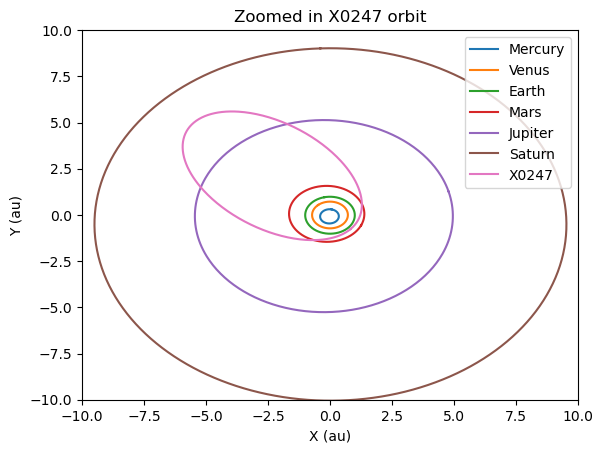

In [15]:
plt.plot(x_mercury,y_mercury,label = 'Mercury')
plt.plot(x_venus,y_venus, label = 'Venus')
plt.plot(x_earth,y_earth,label = "Earth")
plt.plot(x_mars,y_mars,label = 'Mars')
plt.plot(x_jupiter,y_jupiter, label = 'Jupiter')
plt.plot(x_saturn,y_saturn,label = 'Saturn')
plt.plot(x_Object,y_Object,label = 'X0247')

plt.title('Zoomed in X0247 orbit')
plt.xlabel("X (au)")
plt.ylabel("Y (au)")
plt.legend()

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.show()

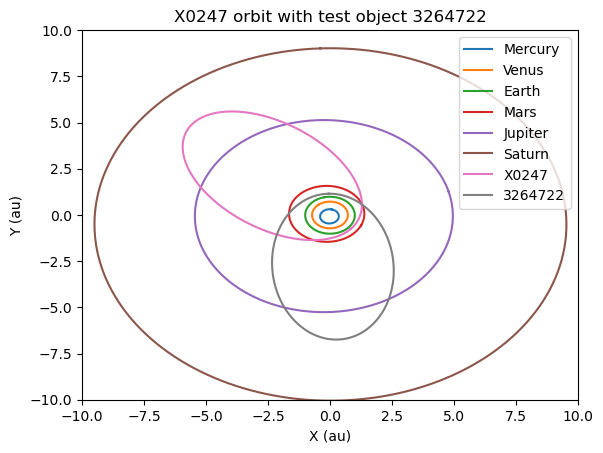

In [16]:
plt.plot(x_mercury,y_mercury,label = 'Mercury')
plt.plot(x_venus,y_venus, label = 'Venus')
plt.plot(x_earth,y_earth,label = "Earth")
plt.plot(x_mars,y_mars,label = 'Mars')
plt.plot(x_jupiter,y_jupiter, label = 'Jupiter')
plt.plot(x_saturn,y_saturn,label = 'Saturn')
plt.plot(x_Object,y_Object,label = 'X0247')

plt.plot(x_3264722,y_3264722,label = '3264722')

plt.title('X0247 orbit with test object 3264722')
plt.xlabel("X (au)")
plt.ylabel("Y (au)")
plt.legend()

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.show()

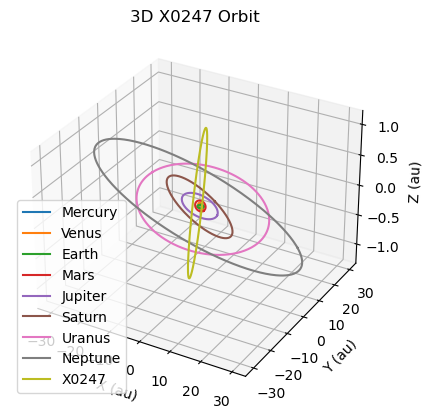

In [17]:
ax = plt.axes(projection='3d')

ax.plot3D(x_mercury,y_mercury,z_mercury,label = 'Mercury')
ax.plot3D(x_venus,y_venus,z_venus, label = 'Venus')
ax.plot3D(x_earth,y_earth,z_earth,label = "Earth")
ax.plot3D(x_mars,y_mars,z_mars,label = 'Mars')
ax.plot3D(x_jupiter,y_jupiter,z_jupiter, label = 'Jupiter')
ax.plot3D(x_saturn,y_saturn,z_saturn,label = 'Saturn')
ax.plot3D(x_uranus,y_uranus,z_uranus,label = 'Uranus')
ax.plot3D(x_neptune,y_neptune,z_neptune,label = 'Neptune')
ax.plot3D(x_Object,y_Object,z_Object,label = 'X0247')

plt.title('3D X0247 Orbit')
plt.xlabel("X (au)")
plt.ylabel("Y (au)")
ax.set_zlabel("Z (au)")

plt.legend()

plt.show()

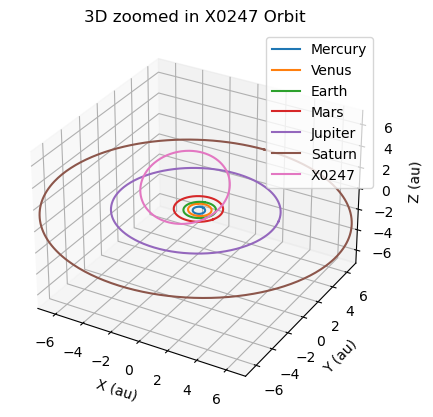

In [18]:
ax = plt.axes(projection='3d')

ax.plot3D(x_mercury,y_mercury,z_mercury,label = 'Mercury')
ax.plot3D(x_venus,y_venus,z_venus, label = 'Venus')
ax.plot3D(x_earth,y_earth,z_earth,label = "Earth")
ax.plot3D(x_mars,y_mars,z_mars,label = 'Mars')
ax.plot3D(x_jupiter,y_jupiter,z_jupiter, label = 'Jupiter')
ax.plot3D(x_saturn,y_saturn,z_saturn,label = 'Saturn')
ax.plot3D(x_Object,y_Object,z_Object,label = 'X0247')

plt.title('3D zoomed in X0247 Orbit')
plt.xlabel("X (au)")
plt.ylabel("Y (au)")
ax.set_zlabel("Z (au)")

plt.xlim(-7,7)
plt.ylim(-7,7)
ax.set_zlim(-7,7)

plt.legend()

plt.show()

In [19]:
def AbsMag_and_Diameter_Calcs(mag,r_helio,r_geo):
    '''
    Calculation fucntion which takes in magnitude,
    the heliocentric position vector, and the geocentric
    position vector and returns absolute magnitude and
    diameter
    
        Parameters:
            mag (float): Observed magnitude of object
            r_helio (array): heliocentric position vector (au)
            r_geo (array): Geocentric position vecotr (au)
        
        Returns:
        H (float): absolute magnitude
        D (float): diameter of object (km)
    
    '''
    A1 = 3.33
    A2 = 1.87
    B1 = 0.63
    B2 = 1.22
    albedo = 0.1 #assuming asteroid based on orbit of object
    
    alpha = (np.arccos(np.dot(r_geo,r_helio)/(np.linalg.norm(r_geo)*
                                              (np.linalg.norm(r_helio)))))
    
    phi1 = np.exp(-A1*np.tan(alpha/2)**B1)
    phi2 = np.exp(-A2*np.tan(alpha/2)**B2)
    
    astphsfunc = 2.5*np.log10((1-G)*phi1+G*phi2)
    
    H = (mag - (5*np.log10(np.linalg.norm(r_helio)*np.linalg.norm(r_geo))
                - astphsfunc))
    D = (1329*10**(-H/5))/((albedo)**0.5)
    
    return(H,D)

def AbsMagDiam_from_Obs(JD,RA,Dec):
    '''
    takes in observations, calls a function which returns 
    heliocentric and geocentric postion, then calls another
    function which returns absolute magnitude and diameter, 
    and returns the mean values of them
    
        Parameters:
            JD (array): array of 3 Julian Dates (unitless)
            RA (array): array of 3 right ascensions (radians)
            Dec (array): array of 3 declinations (radians)
        Returns:
            H (float): mean absolute magnitude
            D (float): mean diameter (km)
        
    '''
    
    r1_helio,r2_helio,r3_helio,r1_geo,r2_geo,r3_geo,rho1,rho2,rho3 = RaDec_Cunningham(JD,RA,Dec)
    
    H1, D1 = AbsMag_and_Diameter_Calcs(mag1,r1_helio,r1_geo)
    H2, D2 = AbsMag_and_Diameter_Calcs(mag2,r2_helio,r2_geo)
    H3, D3 = AbsMag_and_Diameter_Calcs(mag3,r3_helio,r3_geo)
    
    print()
    print('absolute magnitudes')
    print('H1:', H1)
    print('H2:',H2)
    print('H3:',H3)
    H = np.mean([H1,H2,H3])
    D = np.mean([D1,D2,D3])
    
    return(H,D)

H,D = AbsMagDiam_from_Obs(JD,RA,Dec)
print()
print("Absolute Magnitude:",np.round(H,3))
print("Diameter:",np.round(D,3),'km')

nu2: -0.0003747102052722995
Heliocentric distances:
r1: 3.603010089422941
r2: 3.6375943150484464
r3: 3.707658728723964

Geocentric distances
r1: 4.537769590146244
r2: 4.552588569639063
r3: 4.57024707031072

absolute magnitudes
H1: 5.414473923990866
H2: 5.369752898683483
H3: 5.270077324268018

Absolute Magnitude: 5.351
Diameter: 357.607 km


In [20]:
################ Q3 ################

In [21]:
def RA_dec (x,y,z):
    """
    Takes in x,y, and z for a geocentric equitorial coordinate systems
    returns Right Ascension (RA) and Declination (dec) in degrees
    
        Parameters:
            x,y,z (float): positions (au)
        
        Returns:
            RA (float): right ascension (degrees)
            dec (float): declination (degrees)
    """
    
    
    #if statement to take care of bad inputs
    if not isinstance(x,(float,int,np.ndarray)) 
    or not isinstance(y,(float,int,np.ndarray)) 
    or not isinstance(z,(float,int,np.ndarray)):
        return('Input Error, please input Julian Date as float or array of floats')
    
    else:
        
        r = np.sqrt(x**2 + y**2 + z**2)
        dec = np.arcsin(z/r)
        RA = np.arctan2(y, x)
    
    
    
        if RA.size>1: #if the x y z inputs are arrays
            for i in range(len(RA)):
                if RA[i]<0:
                    RA[i] = RA[i]+2*np.pi
        else: #if it is just one set of x y z coords
            if RA<0: 
                RA = RA + 2*np.pi
    

        return(np.degrees(RA), np.degrees(dec)) #convert to degrees for plot

In [22]:
def ApMag(H,r_helio,r_geo):
    '''
    Takes in absolute magnitude, heliocentric position
    vector and geocentric position vector, and returns
    apparent magnitude
    
        Parameters:
            H (float): absolute magnitude
            r_helio (array): heliocentric position (au)
            r_geo (array): geocentric position (au)
        Returns:
            mag(float): apparent magnitude
    '''
    A1 = 3.33
    A2 = 1.87
    B1 = 0.63
    B2 = 1.22
    albedo = 0.1 #assuming asteroid based on orbit of object
    
    alpha = np.arccos(np.dot(r_helio,r_geo)/
                      (np.linalg.norm(r_geo)*(np.linalg.norm(r_helio))))
    
    phi1 = np.exp(-A1*np.tan(alpha/2)**B1)
    phi2 = np.exp(-A2*np.tan(alpha/2)**B2)
    
    astphsfunc = 2.5*np.log10((1-G)*phi1+G*phi2)
    
    mag = H + (5*np.log10(np.linalg.norm(r_helio)*np.linalg.norm(r_geo)) 
                                                           - astphsfunc)
    
    return(mag)

In [23]:
#define needed lists
t0 = JD1+30
RA_list = []
Dec_list = []
time_list = []
mag_list = []

#mean orbital elements from earlier calculations for X047
a_obj = 4.2236606524531775 
e_obj = 0.7316947776904614 
i_obj = 0.43654735484420276 
Omega_obj = -0.7760810128037731 
omega_obj = 0.03710025379203108 
M_obj = 0.6589246843360453


for t in range(0, 90): #calculate over 90 days
    JD = t0+t
    time_list.append(JD)

    r_earthhelio = JD_to_HelioEclip(JD, 1, ME, J0 = 2451545.0)[0]

    Obj_mu = 0.01720209895**2

    r_helio=JD_to_HelioEclip(JD, 1, 0, a_obj, e_obj, i_obj, 
                            Omega_obj, omega_obj, M_obj, 
                             J0=2452465.5000000000000000)[0]

    r_geo = r_helio-r_earthhelio
    
    mag_list.append(ApMag(H,r_helio,r_geo))

    #rotate geocentric into right frame
    ObjGeo= ObliqRot(-ObliqE, r_geo)

    #find ra and decs
    RA_obj, Dec_obj = RA_dec(ObjGeo[0], ObjGeo[1], ObjGeo[2])

    RA_list.append(RA_obj%360)
    Dec_list.append(Dec_obj) 

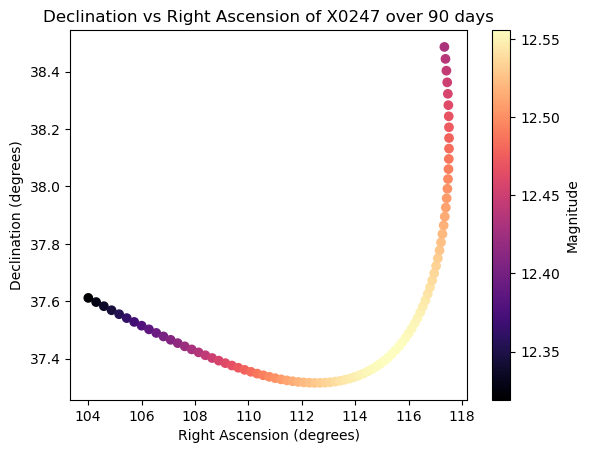

In [24]:
#more plots

plt.scatter(RA_list, Dec_list,c = mag_list,cmap = 'magma')

plt.colorbar(label="Magnitude")
plt.title('Declination vs Right Ascension of X0247 over 90 days')
plt.xlabel("Right Ascension (degrees)")
plt.ylabel("Declination (degrees)")

plt.show()

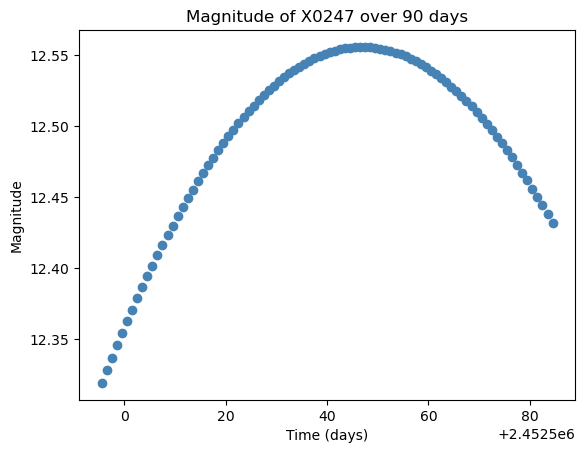

In [26]:
#one more plot :)

plt.scatter(time_list,mag_list,c = 'steelblue')

plt.title('Magnitude of X0247 over 90 days')
plt.xlabel('Time (days)')
plt.ylabel('Magnitude')

plt.show()